# Maximising PV self consumption (PV Utilisation)
This Notebook maximises PV Self consumption by moving the controlled load start time throughout the day
The start time that results in the maximum PV self consumption is saved
## Select a house
| HouseID   |   Load        |
|---------  |   ------      |
|64613      |   hot_water   |
|70210      |   pool        |
|70243      |   hot_water   |
|70277      |   hot_water   |
|91912      |   pool        |
|91910      |   hot_water   |

In [3]:
from os import path
from os import getcwd, listdir
path_to_data = path.join('..', 'data', 'houses')
houses = listdir(path_to_data)
for h in houses: print(path.splitext(h)[0])

64613
69914
70177
70210
70243
70277
91341
91910
91911
91912
97245


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from thesisInitial.cleaning_data import extract_data_from_house, extract_rated_power, extract_average_time_on, apply_new_load
import seaborn as sns
sns.set()
house_id = 69914
load_type = 'hot_water'

### Importing Data and cleaning up

In [5]:
house_id = 64613
data = extract_data_from_house(house_id, load_type)
rated_power = extract_rated_power(data.load)
average_duration = extract_average_time_on(data.load)
data.head()

,load,PV,AC,total_use,grid_import,grid_export
reading_datetime,,,,,,
2019-01-01 00:00:00,0.0194,-0.0733,70.0850,70.0311,70.1044,0.0
2019-01-01 00:05:00,0.0197,-0.0736,69.2019,69.1480,69.2216,0.0
2019-01-01 00:10:00,0.0192,-0.0728,66.6908,66.6372,66.7100,0.0
2019-01-01 00:15:00,0.0194,-0.0733,68.1369,68.0830,68.1563,0.0
2019-01-01 00:20:00,0.0225,-0.0742,81.0847,81.0330,81.1072,0.0


In [6]:
from time import time
def generate_load(index, start_time):
    duration = pd.Timedelta(value=average_duration,unit='m')
    y = pd.Series(np.zeros(len(pv_day)), index = index)
    start_time = pd.Timestamp(index[0]) + pd.Timedelta(value=start_time, unit='h')
    end_time = start_time + duration
    y[start_time:end_time] = (rated_power / 12) * 1000
    return y

def extract_load(load, start_time):
    pass

date_range = ['2019-01','2019-01']

new_pv_utilisation = pd.Series(dtype='float64')
new_load = pd.Series(dtype='float64')
days_in_set = data[date_range[0]:date_range[1]].index.date
days_in_set = np.unique(days_in_set)
start = time()
for day in days_in_set:
    date = str(day)
    print(date)
    con_without_load = data[date].total_use - data[date].load
    pv_day = data[date].PV
    max_pv_util = pd.Series(dtype='float64')
    max_time = 0
    for i in range(int((24 * 60) / 5)):
        index = con_without_load.index
        load = generate_load(index, i)
        con_load = con_without_load + load
        pv_util = pd.concat([pv_day, con_load], axis=1).min(axis=1).clip(lower=0)
#         pv_util.rename('pv_util')
        if pv_util.sum() > max_pv_util.sum():
            max_pv_util = pv_util
            max_load = load
            max_time = i
    new_pv_utilisation = new_pv_utilisation.append(max_pv_util)
    new_load = new_load.append(max_load)
print('Time taken ' + '{:.2f}'.format(time()-start) + 's')
# pv_utilisation[str(days_in_set[0])].plot()
# new_pv_utilisation.plot()
# plt.show()
print('done')

2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
Time taken 14.74s
done


The reason the load total is greater for after shifting is the generate_load function
makes a load from the average_duration and rated_power.

This is an estimation of the load

In [12]:
data_range = data[date_range[0]:date_range[1]]
pv_utilisation = pd.concat([data_range.PV, data_range.total_use], axis=1).min(axis=1).clip(lower=0)
house_consumption_when_loadon_pvgen = np.where(((data_range.PV > 1) & (load > 10)), pv_utilisation, 0)
load_serviced_by_PV = (house_consumption_when_loadon_pvgen - data_range.total_use - data_range.load).clip(lower=0)
print('Before PV Self Consumption Maximising')
print("load total " + "{:.2f}".format(data_range.load.sum() / 1000) + "kWh")
print("load serviced by PV Total " + "{:.2f}".format(load_serviced_by_PV.sum() / 1000) + "kWh")
print()
house_consumption_when_loadon_pvgen = pd.DataFrame(index=data_range.PV.index)
house_consumption_when_loadon_pvgen['power'] = np.where(((data_range.PV > 1) & (new_load > 10)), new_pv_utilisation, 0)
house_consumption_when_loadon_pvgen=house_consumption_when_loadon_pvgen.power
load_serviced_by_PV = (house_consumption_when_loadon_pvgen - data_range.total_use - data_range.load).clip(lower=0)
print('After PV Self Consumption Maximising')
print("load total " + "{:.2f}".format(new_load.sum() / 1000) + "kWh")
print("load serviced by PV Total " + "{:.2f}".format(load_serviced_by_PV.sum() / 1000) + "kWh")

Before PV Self Consumption Maximising
load total 56.95kWh
load serviced by PV Total 0.00kWh

After PV Self Consumption Maximising
load total 78.19kWh
load serviced by PV Total 65.89kWh


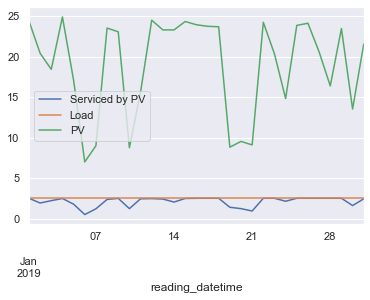

In [8]:
load_serviced_by_PV_24h = load_serviced_by_PV.resample('24h').sum() / 1000
load_24h = new_load.resample('24h').sum() / 1000
pv_24h = data_range.PV.resample('24h').sum() / 1000

load_serviced_by_PV_24h.plot(label='Serviced by PV')
load_24h.plot(label='Load')
pv_24h.plot(label='PV')
plt.legend()
plt.show()